# Trading Strategy

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
import statsmodels.api as sm
from backtesting import Backtest, Strategy
from scipy.stats import spearmanr
import argparse
from sklearn.exceptions import ConvergenceWarning
import warnings
warnings.filterwarnings('ignore', category=ConvergenceWarning)
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

In [5]:
# read data
df_vix = pd.read_csv("../2_data/daily_vix.csv", parse_dates=["date"])
df_nvda = pd.read_csv("../2_data/daily_nvda.csv", parse_dates=["Date"]).rename(columns={"Date": "date"})
df_sentiscores = pd.read_csv("../2_data/daily_topic0_sentiment_stats.csv", parse_dates=["date"])

# filter out weekends
start_date = "2019-01-01"
end_date = "2022-02-28"
date_range = pd.date_range(start=start_date, end=end_date)
df_all = pd.DataFrame({"date": date_range})

# Add Prefix：VIX
df_vix = df_vix[df_vix["date"].between(start_date, end_date)]
df_vix = df_vix.rename(columns=lambda x: f"vix_{x}" if x != "date" else x)

# Add Prefix：NVDA
df_nvda.columns = [col.lower() for col in df_nvda.columns]
df_nvda = df_nvda[df_nvda["date"].between(start_date, end_date)]
df_nvda = df_nvda.rename(columns=lambda x: f"nvda_{x}" if x != "date" else x)

# Sentiment data is also filtered for date ranges
df_sentiscores = df_sentiscores[df_sentiscores["date"].between(start_date, end_date)]

# merge all dataframes
df_merged = df_all.merge(df_sentiscores[["date", "topic_0_sentiment_std", "topic_0_avg_sentiment_score"]], on="date", how="left") \
                  .merge(df_vix, on="date", how="left") \
                  .merge(df_nvda, on="date", how="left")

# View Missing Values
print("Missing values per column:")
print(df_merged.isnull().sum())

# View merged data
print(df_merged.tail())

df_merged.to_csv("../2_data/factor_data_0522.csv", index=False)


Missing values per column:
date                             0
topic_0_sentiment_std          211
topic_0_avg_sentiment_score     92
vix_open                       359
vix_high                       359
vix_low                        359
vix_close                      359
nvda_open                      359
nvda_high                      359
nvda_low                       359
nvda_close                     359
nvda_volume                    359
dtype: int64
           date  topic_0_sentiment_std  topic_0_avg_sentiment_score  \
1150 2022-02-24               0.691492                     0.066667   
1151 2022-02-25               0.603023                     0.000000   
1152 2022-02-26               0.577350                     0.500000   
1153 2022-02-27               0.447214                    -0.200000   
1154 2022-02-28               0.707107                     0.500000   

       vix_open   vix_high    vix_low  vix_close  nvda_open  nvda_high  \
1150  37.500000  37.790001  29.450001  

In [6]:
# read data
df = pd.read_csv('factor_data_0522.csv', parse_dates=['date'])
df = df.sort_values('date').reset_index(drop=True)
# Screen out non-trading days first (e.g., days with no stock prices)
df = df.dropna(subset=['nvda_close', 'vix_close'])

# Tectonic Techniques and Sentiment Factors
df['nvda_return'] = df['nvda_close'].pct_change()
df['nvda_ma5'] = df['nvda_close'].rolling(window=5).mean()
df['nvda_volatility'] = df['nvda_return'].rolling(window=5).std()
df['ma_deviation'] = (df['nvda_close'] - df['nvda_ma5']) / df['nvda_ma5']

df['vix_change'] = df['vix_close'].pct_change()
df['vix_range'] = (df['vix_high'] - df['vix_low']) / df['vix_close']

df['volume_change'] = df['nvda_volume'].pct_change()
df['volume_zscore'] = (df['nvda_volume'] - df['nvda_volume'].rolling(10).mean()) / df['nvda_volume'].rolling(10).std()

df['future_return'] = df['nvda_close'].pct_change().shift(-5)

df['sentiment_diff'] = df['topic_0_avg_sentiment_score'].diff()
df['sentiment_ma3'] = df['topic_0_avg_sentiment_score'].rolling(3).mean()
df['sentiment_ema'] = df['topic_0_avg_sentiment_score'].ewm(span=5).mean()
df['sentiment_zscore'] = (df['topic_0_avg_sentiment_score'] - df['topic_0_avg_sentiment_score'].rolling(10).mean()) / df['topic_0_avg_sentiment_score'].rolling(10).std()
df['ma_deviation_sq'] = df['ma_deviation'] ** 2
df['vix_change_sq'] = df['vix_change'] ** 2
df['interaction_1'] = df['ma_deviation'] * df['vix_change']
df['interaction_2'] = df['sentiment_zscore'] * df['ma_deviation']
df['interaction_3'] = df['sentiment_diff'] * df['vix_change']


raw_factors = [
    # Technical factors
    'ma_deviation', 'nvda_volatility', 'vix_change', 'vix_range',
    'volume_change', 'volume_zscore',
    
    # Sentiment factors
    'topic_0_avg_sentiment_score', 'topic_0_sentiment_std', 'sentiment_diff',
    'sentiment_ma3', 'sentiment_ema', 'sentiment_zscore',
    
    # nonlinear 
    'ma_deviation_sq', 'vix_change_sq',
    
    # interaction
    'interaction_1', 'interaction_2', 'interaction_3'
]

df = df.dropna(subset=raw_factors + ['future_return']).copy()

# 5. Standardize the factors
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
df[[f + '_z' for f in raw_factors]] = scaler.fit_transform(df[raw_factors])

# 
df['index_A'] = df[['ma_deviation_z', 'nvda_volatility_z', 'vix_change_z']].mean(axis=1)
df['index_B'] = df[['ma_deviation_z', 'nvda_volatility_z', 'vix_change_z',
                    'topic_0_avg_sentiment_score_z', 'topic_0_sentiment_std_z', 'vix_range_z',
                    'volume_change_z', 'volume_zscore_z']].mean(axis=1)

FileNotFoundError: [Errno 2] No such file or directory: 'factor_data_0522.csv'

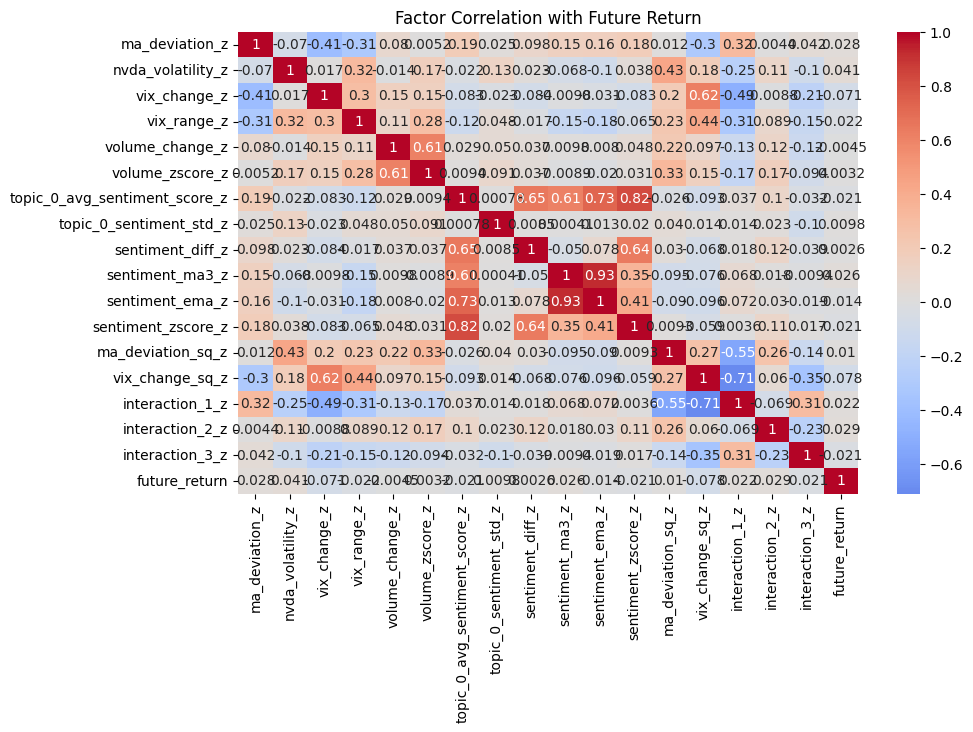

📌 XGBoost Order of importance ：
                        feature  importance
15                interaction_2    0.100834
5                 volume_zscore    0.086965
6   topic_0_avg_sentiment_score    0.071263
3                     vix_range    0.067911
13                vix_change_sq    0.064265
1               nvda_volatility    0.062883
16                interaction_3    0.060736
10                sentiment_ema    0.060606
11             sentiment_zscore    0.056468
9                 sentiment_ma3    0.056195
12              ma_deviation_sq    0.052881
4                 volume_change    0.052850
2                    vix_change    0.049749
8                sentiment_diff    0.045838
14                interaction_1    0.045686
7         topic_0_sentiment_std    0.037068
0                  ma_deviation    0.027803


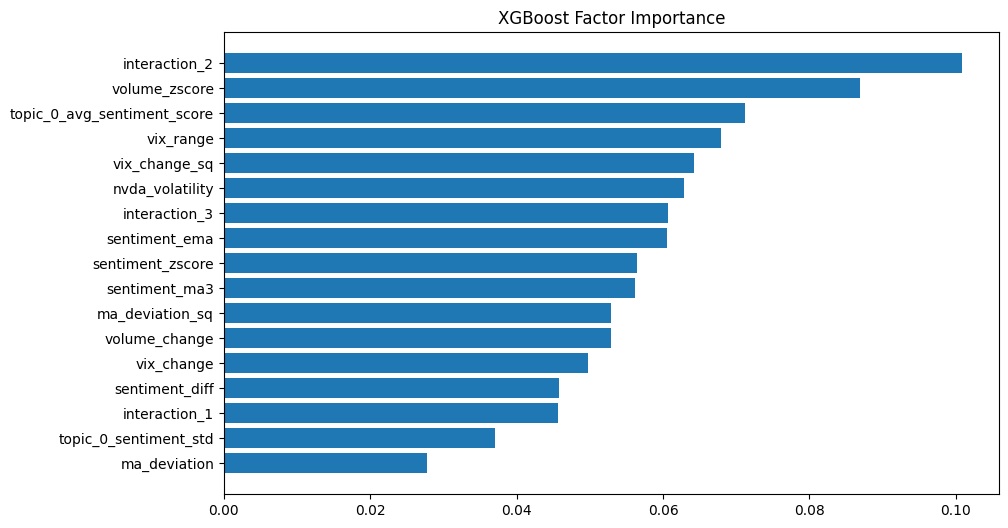

In [ ]:
# ========== visualization ==========
cor_matrix = df[[f + '_z' for f in raw_factors] + ['future_return']].corr()
plt.figure(figsize=(10, 6))
sns.heatmap(cor_matrix, annot=True, cmap='coolwarm', center=0)
plt.title("Factor Correlation with Future Return")
plt.show()

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import TimeSeriesSplit
from sklearn.linear_model import LassoCV

X = df[raw_factors].copy()
y = df['future_return']

# Fill in missing values or delete missing rows
X = X.dropna()
y = y.loc[X.index]

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

import xgboost as xgb
import matplotlib.pyplot as plt

model = xgb.XGBRegressor(n_estimators=100, max_depth=3, learning_rate=0.1, random_state=42)
model.fit(X_scaled, y)

# Acquisition Importance
importances = model.feature_importances_
importance_df = pd.DataFrame({'feature': X.columns, 'importance': importances})
importance_df = importance_df.sort_values(by='importance', ascending=False)

print("📌 XGBoost Order of importance ：")
print(importance_df)

# Visualization
plt.figure(figsize=(10,6))
plt.barh(importance_df['feature'], importance_df['importance'])
plt.gca().invert_yaxis()
plt.title("XGBoost Factor Importance")
plt.show()

# Select the top N factors
xgb_selected = importance_df.query('importance > 0.01')['feature'].tolist()


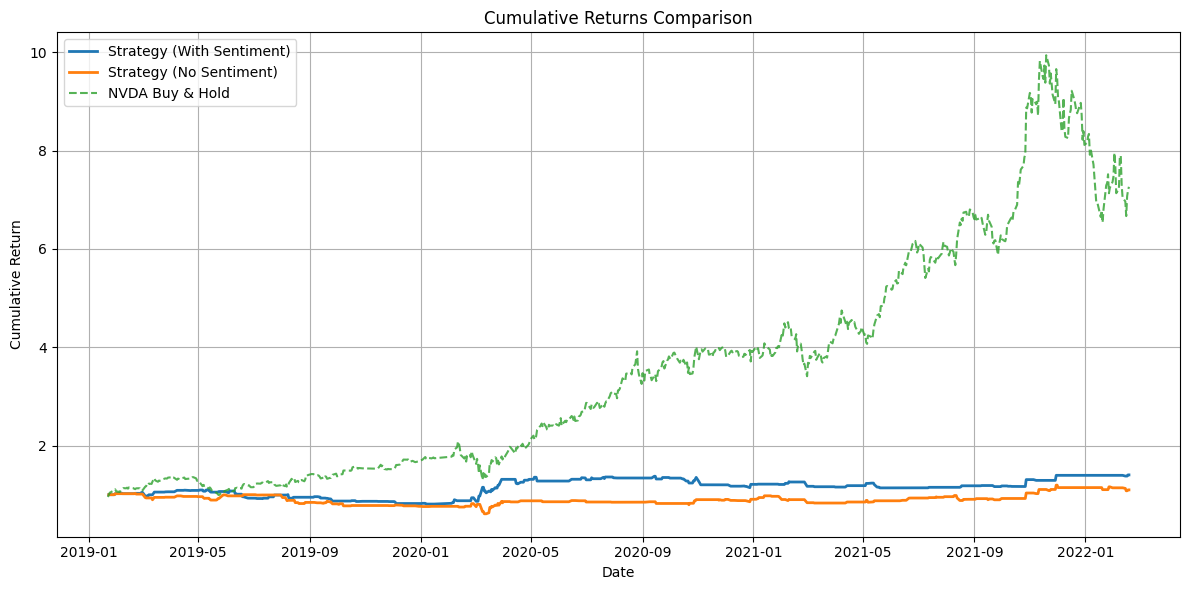

==== Performance Comparison ====
With Sentiment     - Annual Return: 14.93%, Volatility: 25.73%, Sharpe: 0.58
Without Sentiment  - Annual Return: 7.13%, Volatility: 27.89%, Sharpe: 0.26
Benchmark (NVDA)   - Annual Return: 80.62%, Volatility: 48.96%, Sharpe: 1.65


In [ ]:
from sklearn.preprocessing import StandardScaler
import numpy as np
import matplotlib.pyplot as plt

# === 1. Original Strategy: Include Emotional Factors===
selected_all = [
    'nvda_volatility', 'vix_change', 'sentiment_ma3', 'interaction_3',
    'vix_change_sq', 'topic_0_sentiment_std', 'sentiment_ema', 'ma_deviation',
    'topic_0_avg_sentiment_score', 'volume_change', 'sentiment_diff'
]

# New strategy: no sentiment factor
sentiment_features = ['sentiment_ma3', 'interaction_3', 'topic_0_sentiment_std', 'sentiment_ema',
                      'topic_0_avg_sentiment_score', 'sentiment_diff']
selected_non_sentiment = [f for f in selected_all if f not in sentiment_features]

# Standardized and lagging (to prevent future information leakage)
df_all_shifted = df[selected_all].shift(1)
df_non_sent_shifted = df[selected_non_sentiment].shift(1)

scaler_all = StandardScaler()
scaler_non = StandardScaler()

df_all_scaled = pd.DataFrame(scaler_all.fit_transform(df_all_shifted), columns=selected_all, index=df.index)
df_non_scaled = pd.DataFrame(scaler_non.fit_transform(df_non_sent_shifted), columns=selected_non_sentiment, index=df.index)

# === 2. Constructing integrated signals ===
weights_all = importance_df.set_index('feature').loc[selected_all]['importance'].values
weights_all = weights_all / weights_all.sum()

weights_non = importance_df.set_index('feature').loc[selected_non_sentiment]['importance'].values
weights_non = weights_non / weights_non.sum()

df['composite_signal_all'] = df_all_scaled.mul(weights_all, axis=1).sum(axis=1)
df['composite_signal_non'] = df_non_scaled.mul(weights_non, axis=1).sum(axis=1)

# === 3. Signal to position ===
upper_all = df['composite_signal_all'].quantile(0.90)
lower_all = df['composite_signal_all'].quantile(0.10)

upper_non = df['composite_signal_non'].quantile(0.90)
lower_non = df['composite_signal_non'].quantile(0.10)

df['position_all'] = 0
df.loc[df['composite_signal_all'] > upper_all, 'position_all'] = 1
df.loc[df['composite_signal_all'] < lower_all, 'position_all'] = -1

df['position_non'] = 0
df.loc[df['composite_signal_non'] > upper_non, 'position_non'] = 1
df.loc[df['composite_signal_non'] < lower_non, 'position_non'] = -1


# === 4.Strategy Returns and Cumulative Returns ===
df['return_all'] = df['position_all'].shift(1) * df['future_return']
df['return_non'] = df['position_non'].shift(1) * df['future_return']
df['cumulative_all'] = (1 + df['return_all']).cumprod()
df['cumulative_non'] = (1 + df['return_non']).cumprod()
df['cumulative_nvda'] = (1 + df['future_return']).cumprod()

# === 5.drawing comparison  ===
plt.figure(figsize=(12, 6))
plt.plot(df['date'], df['cumulative_all'], label='Strategy (With Sentiment)', linewidth=2)
plt.plot(df['date'], df['cumulative_non'], label='Strategy (No Sentiment)', linewidth=2)
plt.plot(df['date'], df['cumulative_nvda'], label='NVDA Buy & Hold', linestyle='--', alpha=0.8)
plt.title('Cumulative Returns Comparison')
plt.xlabel('Date')
plt.ylabel('Cumulative Return')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# === 6. Performance evaluation function ===
def evaluate_performance(returns):
    ann_ret = np.mean(returns) * 252
    ann_vol = np.std(returns) * np.sqrt(252)
    sharpe = ann_ret / ann_vol if ann_vol != 0 else np.nan
    return ann_ret, ann_vol, sharpe

# === 7.Output Performance Comparison  ===
s1_ret, s1_vol, s1_sharpe = evaluate_performance(df['return_all'].dropna())
s2_ret, s2_vol, s2_sharpe = evaluate_performance(df['return_non'].dropna())
b_ret, b_vol, b_sharpe = evaluate_performance(df['future_return'].dropna())

print("==== Performance Comparison ====")
print(f"With Sentiment     - Annual Return: {s1_ret:.2%}, Volatility: {s1_vol:.2%}, Sharpe: {s1_sharpe:.2f}")
print(f"Without Sentiment  - Annual Return: {s2_ret:.2%}, Volatility: {s2_vol:.2%}, Sharpe: {s2_sharpe:.2f}")
print(f"Benchmark (NVDA)   - Annual Return: {b_ret:.2%}, Volatility: {b_vol:.2%}, Sharpe: {b_sharpe:.2f}")